- In this notebook, I trained the ONet, which is the last part of the model
- As I mentioned in the first notebook (step 1), I will not show the repetitive parts. 

## Read ONet txt file
- In this part, it reads the txt file generated from the step 4.
- The format of the txt file is:
        image_path * label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 + ... + label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2 * \n
- The output of this function is in the format:
        [image_path,[label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2], ... , [label, gt_x1, gt_y1, gt_x2, gt_y2, cr_x1, cr_y1, cr_x2, cr_y2]]

In [3]:
def create_onet_data_txt_parser(txt_path, img_dir,num_data=5000):

    if osp.exists(txt_path):
        img_faces = []
        with open(txt_path, 'r') as f:
            l = []
            lines = list(map(lambda line: line.strip().split('\n'), f))
            lines = [i[0] for i in lines]   
            shuffle(lines)
            img_count=0
            for line in lines:     
                if num_data is not None and img_count>=num_data:
                    break
                img_label_gt_crop=line.split('*')  
                real_img_path=img_label_gt_crop[0]
                label_gt_crop=[i.split(',') for i in img_label_gt_crop[1].split('+')]

                if osp.exists(real_img_path):
                    try:
                        Image.open(real_img_path).verify()
                        img_faces.append([real_img_path, label_gt_crop]) 
                        img_count+=1
                        
                    except:
                        print("*** warning:cannot open",real_img_path)

                else:
                    print("*** warning:image path invalid",real_img_path)

                

        return img_faces
    else:
        print('*** warning:WILDER_FACE txt file not exist!')


## Create the Inplace Dataset for ONet
- The input of this part is generated from the **create_onet_data_txt_parser** function

- The output of the **self.\__getitem \__ ** will be:
      (img_tensor, label, offset, landmark_flag, landmark)
      
- The **self.\__getitem \__ ** do the following things:  

    * It opens the corresponding image, and gets the figures of:
            label:            1 (if have face), 0 (else)
            ground truth boxes:  (gt_x1, gt_y1, gt_x2, gt_y2) 
            cropped boxes:      (cr_x1, cr_y1, cr_x2, cr_y2)
    * It randomly chooses a crop box from the list of crop boxes
    * It crops the image according to the seleted crop box
    * It calulated the offset of the crop box

In [4]:
class InplaceDataset(data.Dataset):
    def __init__(self,  img_faces, cropsize):
        
        def cal_offset(face, box):
            offset = [
                (face[0] - box[0]) / float(box[2] - box[0]),
                (face[1] - box[1]) / float(box[3] - box[1]),
                (face[2] - box[2]) / float(box[2] - box[0]),
                (face[3] - box[3]) / float(box[3] - box[1]),
                ]
            return offset  
        
        self.img_path=[]
        self.label_offset_crop=[]
        for img_face in img_faces:

            img_path=img_face[0]
            label_box_crop=[]
            
            for i in img_face[1]:
                try:
                    label=i[0]
                    label=[1.0 if label in ['p', 'pf', 'l'] else 0.0]
                    gt=[int(j) for j in i[1:5]]
                    crop_box=[int(j) for j in i[5:9]]
                    offset=cal_offset(gt, crop_box)
                    label_box_crop.append([label,offset,crop_box])
                except:
                    continue
            if len(label_box_crop) != 0:
                self.img_path.append(img_path)
                self.label_offset_crop.append(label_box_crop)
            else:
                print(img_path,'no box')
        self.crop_size = cropsize
        print('===> data set size:{}'.format(self.__len__()))    
      
    def __getitem__(self, index):
        
        img= np.array(Image.open(self.img_path[index]).convert('RGB'))
        label_box_crop=self.label_offset_crop[index]
        label,offset,crop_box=label_box_crop[random.randint(0,len(label_box_crop))]
        
        label=torch.FloatTensor(label)
        offset=torch.FloatTensor(offset)
        
        crop_img = img[crop_box[1]:crop_box[3], crop_box[0]:crop_box[2], :]
        crop_img = Image.fromarray(crop_img, mode='RGB').resize((self.crop_size , self.crop_size ), resample=PIL.Image.BILINEAR)    
        img_tensor = transforms.ToTensor()(crop_img)     

        
        landmark_flag = torch.FloatTensor([0.0])
        landmark = torch.FloatTensor(10 * [0.0])
        
        return (img_tensor, label, offset, landmark_flag, landmark)

    def __len__(self):
        return len(self.img_path)

## ONet Model
Here show the structure of the ONet Model:

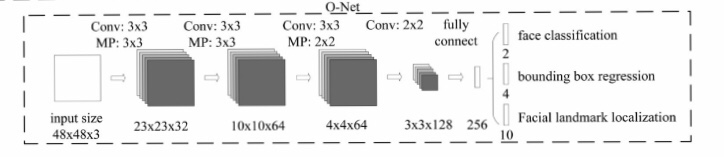

In [7]:
Image.open('ONet Model.jpg')

In [5]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias, 0.1)


class O_Net(nn.Module):
    def __init__(self):
        super(O_Net, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1),  # conv1
            nn.PReLU(),  # prelu1
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool1
            nn.Conv2d(32, 64, kernel_size=3, stride=1),  # conv2
            nn.PReLU(),  # prelu2
            nn.MaxPool2d(kernel_size=3, stride=2),  # pool2
            nn.Conv2d(64, 64, kernel_size=3, stride=1),  # conv3
            nn.PReLU(),  # prelu3
            nn.MaxPool2d(kernel_size=2, stride=2),  # pool3
            nn.Conv2d(64, 128, kernel_size=2, stride=1),  # conv4
            nn.PReLU()  # prelu4
        )
        self.conv5 = nn.Linear(128 * 2 * 2, 256)  # conv5
        self.prelu5 = nn.PReLU()  # prelu5
        # detection
        self.conv6_1 = nn.Linear(256, 1)
        # bounding box regression
        self.conv6_2 = nn.Linear(256, 4)
        # lanbmark localization
        self.conv6_3 = nn.Linear(256, 10)
        # weight initiation weih xavier
        self.apply(weights_init)

    def forward(self, x):
        x = self.pre_layer(x)
        x = x.view(x.size(0), -1)
        x = self.conv5(x)
        x = self.prelu5(x)
        # detection
        det = torch.sigmoid(self.conv6_1(x))
        box = self.conv6_2(x)
        landmark = self.conv6_3(x)
        return det, box, landmark




## Training
- If there is no prediction box, it will print:
         "image_path no box"

In [ ]:
DEVICE = torch.device('cuda:0')
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
train_txt_path='../input/onet-txt/onet_train_data.txt'
eval_txt_path='../input/onet-txt/onet_eval_data.txt'
train_img_path='../input/wider-data/WIDER/WIDER_train'
eval_img_path='../input/wider-data/WIDER/WIDER_val'
train_num=None
eval_num=None
class_data_augment = 3 
landmark_data_dir = None 
landmark_data_txt_path = None 
LR = 0.001
EPOCH = 60
BATCH_SIZE = 32
NUM_WORKS = 8
Onet_loss_config = [1.0, 0.5, 0]

train_img_faces = create_onet_data_txt_parser(train_txt_path,train_img_path ,num_data=train_num)
eval_img_faces = create_onet_data_txt_parser(eval_txt_path,eval_img_path ,num_data=eval_num)
train_IDS=InplaceDataset(train_img_faces, cropsize=48)
eval_IDS=InplaceDataset(eval_img_faces, cropsize=48)
Train_Loader=DataLoader(train_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
Eval_Loader=DataLoader(eval_IDS,batch_size=BATCH_SIZE,shuffle=True,num_workers=NUM_WORKS,pin_memory=False)
train_num=len(train_IDS)
eval_num=len(eval_IDS)

net=O_Net().cuda()
for param in net.conv6_3.parameters():
    param.requires_grad = False

In [9]:
train_losses,eval_losses,onet=train_net(net, net_name='onet',  loss_config=Onet_loss_config)

===> epoch:0	| train_loss:0.45101356	| time:354.97998710s
                | eval_loss:0.40923188	| time:90.99350671s
===> epoch:1	| train_loss:0.37260762	| time:358.33446333s
                | eval_loss:0.32277510	| time:88.66156415s
===> epoch:2	| train_loss:0.30710255	| time:350.23388050s
                | eval_loss:0.25319906	| time:86.97400401s
===> epoch:3	| train_loss:0.26106860	| time:356.43782229s
                | eval_loss:0.31347346	| time:88.58144224s
===> epoch:4	| train_loss:0.24217463	| time:350.85984769s
                | eval_loss:0.22486762	| time:87.40568429s
===> epoch:5	| train_loss:0.20217920	| time:358.48172803s
                | eval_loss:0.26469755	| time:87.73103258s
===> epoch:6	| train_loss:0.19209137	| time:361.80197465s
                | eval_loss:0.19266828	| time:88.60719713s
===> epoch:7	| train_loss:0.19670790	| time:357.15501066s
                | eval_loss:0.20177093	| time:89.26509664s
===> epoch:8	| train_loss:0.18374092	| time:355.20065837s
      

## Show the Loss Curve

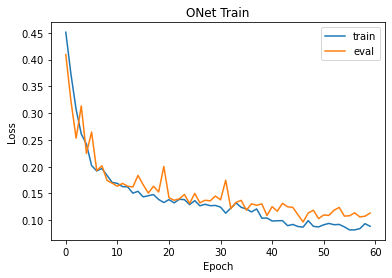

In [10]:
x=np.arange(len(train_losses))
plt.plot(x,train_losses,label='train')
plt.plot(x,eval_losses,label='eval')
plt.title('ONet Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()